In [279]:
import pandas as pd
DAY_MAP = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
# Read the POI dataset
pois = pd.read_csv('pois.csv', sep=' ', header=0)
# Read the Queries dataset
queries = pd.read_csv('queries.csv', sep=' ', header=0)


# Preprocessing

In [280]:
# The timestamp in the queries dataset is in hours from the start of the dataset which is the midnight of the sunday connecting to monday
# We'll create a new column called day of the week which will be the day of the week of the timestamp
queries['day_of_week'] = queries['timestamp'].apply(lambda x: (x // 24) % 7)
# We map the number to the string representation of the day of the week
# queries['day_of_week'] = queries['day_of_week'].map(DAY_MAP)
# Now we create a new column called hour of day which will be the hour of the day of the timestamp
queries['hour_of_day'] = queries['timestamp'].apply(lambda x: x % 24)
# Finally we update the timestamp column to be the day number, i.e. the number of days since the start of the dataset
queries['timestamp'] = queries['timestamp'].apply(lambda x: x // 24)
# Change timestamp column name to day
queries.rename(columns={'timestamp': 'day'}, inplace=True)

In [281]:
queries.poi_type_query.value_counts()

restaurant     5218
cafeteria      5131
club           2145
gym            2063
bar            2051
supermarket    2001
dojo           1834
Name: poi_type_query, dtype: int64

In [282]:
pois.poi_type.value_counts()

dojo                135
bar                 114
cafeteria           114
restaurant          112
appartment_block    112
club                110
supermarket         108
gym                 107
villa                88
laboratory           26
company              19
office               15
Name: poi_type, dtype: int64

In [283]:
# Now we want to assess the privacy leakage of the queries dataset
# We assume that each ip_address maps to a unique user
# For each user we will try to find the following information:
# 1. The user's home location
# 2. The user's work location
# 3. The user's favorite place to eat
# 4. The user's favorite place to shop
# 5. The user's hobby
# 6. The user's entertainment preference
# For this purpose we group the POIs into these categories
POI_MAPS = {
    "villa": "home",
    "appartment_block": "home",
    "restaurant": "meal",
    "cafeteria": "meal",
    "laboratory": "work",
    "company": "work",
    "office": "work",
    "supermarket": "shopping",
    "dojo": "hobby",
    "gym": "hobby",
    "bar": "entertainment",
    "club": "entertainment"
}
# Save the original poi_type column
pois['poi_type_original'] = pois['poi_type']
# Save the original poi_type_query column
queries['poi_type_query_original'] = queries['poi_type_query']
# We replace the poi_type column with the category of the POI
pois['poi_type'] = pois['poi_type'].map(POI_MAPS)
queries['poi_type_query'] = queries['poi_type_query'].map(POI_MAPS)

In [284]:
queries.head()

,ip_address,lat,lon,day,poi_type_query,day_of_week,hour_of_day,poi_type_query_original
0,34.101.177.245,46.532942,6.591174,0.0,meal,0.0,14.912448,cafeteria
1,34.101.177.245,46.532942,6.591174,0.0,meal,0.0,14.912448,restaurant
2,34.101.177.245,46.550342,6.602852,0.0,meal,0.0,18.024657,restaurant
3,34.101.177.245,46.550342,6.602852,0.0,meal,0.0,18.024657,cafeteria
4,34.101.177.245,46.532942,6.591174,1.0,meal,1.0,12.334539,cafeteria


# Privacy leakage

Now that the data is preprocessed we'll try to infer information about each user as follows:

In [285]:
from seaborn import scatterplot
from matplotlib import pyplot as plt
from matplotlib import rcParams
hue = {
    'home': 'red',
    'work': 'green',
    'meal': 'blue',
    'shopping': 'yellow',
    'hobby': 'orange',
    'entertainment': 'purple'
}

# Below function finds the given user's home, work, meal, shopping, hobby and entertainment locations
# And also plots if the plot parameter is set to True
def plot_user_queries(user, plot):
    # For this user find all the queries that he made
    user_queries = queries[queries['ip_address'] == user]
    # Now in these queries find the ones that are in the pois dataframe
    # We do this by findting the rows in POIs dataframe that have the same lat and lon as the queries dataframe
    user_queries = user_queries.merge(pois, on=['lat', 'lon'], how='inner')
    # Drop the dupicate rows that have the same lat and lon
    user_queries.drop_duplicates(subset=['lat', 'lon'], inplace=True)
    # Get the work location of the user
    work_location = user_queries[user_queries['poi_type'] == 'work']
    # Get the home location of the user
    home_location = user_queries[user_queries['poi_type'] == 'home']
    # Get the meal location of the user
    meal_location = user_queries[user_queries['poi_type'] == 'meal']
    # Get the shopping location of the user
    shopping_location = user_queries[user_queries['poi_type'] == 'shopping']
    # Get the hobby location of the user
    hobby_location = user_queries[user_queries['poi_type'] == 'hobby']
    # Get the entertainment location of the user
    entertainment_location = user_queries[user_queries['poi_type'] == 'entertainment']
    # Print info
    if plot:
        print(f'User: {user}, Work: {work_location.shape[0]}, Home: {home_location.shape[0]}, Meal: {meal_location.shape[0]}, Shopping: {shopping_location.shape[0]}, Hobby: {hobby_location.shape[0]}, Entertainment: {entertainment_location.shape[0]}')
        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 10))
        # Plot the POIs
        scatterplot(data=pois, x='lon', y='lat', ax=ax, legend=False, s=100, color='black')
        # Plot the user's queries
        scatterplot(data=user_queries, x='lon', y='lat', hue='poi_type', ax=ax, s=100, palette=hue)
    return {
        'user': user,
        'work': work_location,
        'home': home_location,
        'meal': meal_location,
        'shopping': shopping_location,
        'hobby': hobby_location,
        'entertainment': entertainment_location
    }

To test our new function we use the user that has the most amount of queries

The user with the most amount of queries is 113.167.82.177 with 109 queries
User: 113.167.82.177, Work: 1, Home: 1, Meal: 2, Shopping: 0, Hobby: 4, Entertainment: 3


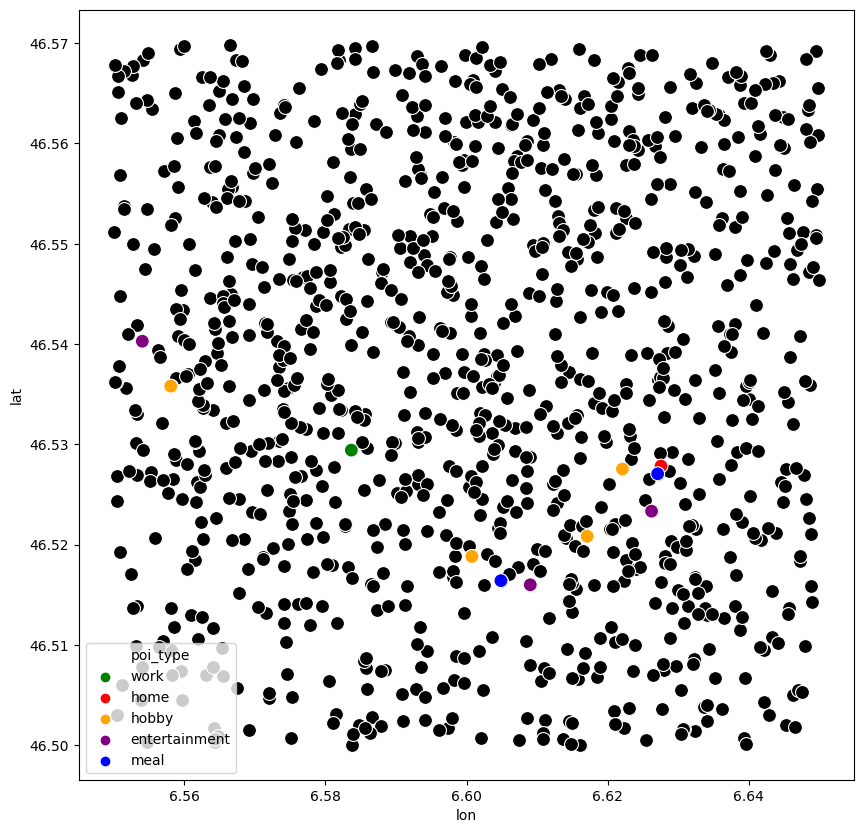

In [286]:
# For better visualization, let's get one user and plot his queries on a map for over a week
# Let's choose the user with the most amount of queries
user, count = queries.groupby('ip_address').count().sort_values(by='day', ascending=False).head(1).index[0], queries.groupby('ip_address').count().sort_values(by='day', ascending=False).head(1).day[0]
print(f'The user with the most amount of queries is {user} with {count} queries')
info = plot_user_queries(user, True)

In [287]:
# Now we repeat the same process for all the users
user_infos = {}
for user in queries['ip_address'].unique():
    user_info = plot_user_queries(user, False)
    if(user_info['home'].shape[0] != 1):
        print(f'{user_info["user"]} has {user_info["home"].shape[0]} home locations')
    if(user_info['work'].shape[0] != 1):
        print(f'{user_info["user"]} has {user_info["work"].shape[0]} work locations')
    user_infos[user] = user_info

# Further inferences

We notice from the above cell that each user lives and works in one place. 

We also can assume that no user works in one of the POIs that we have classified as meal, hobby and etc.

With these information we try to infer further information about users, for example we'll try to find users who work in the same place and/or who live in the same place.

We first start with analyzing who lives in what type of home?

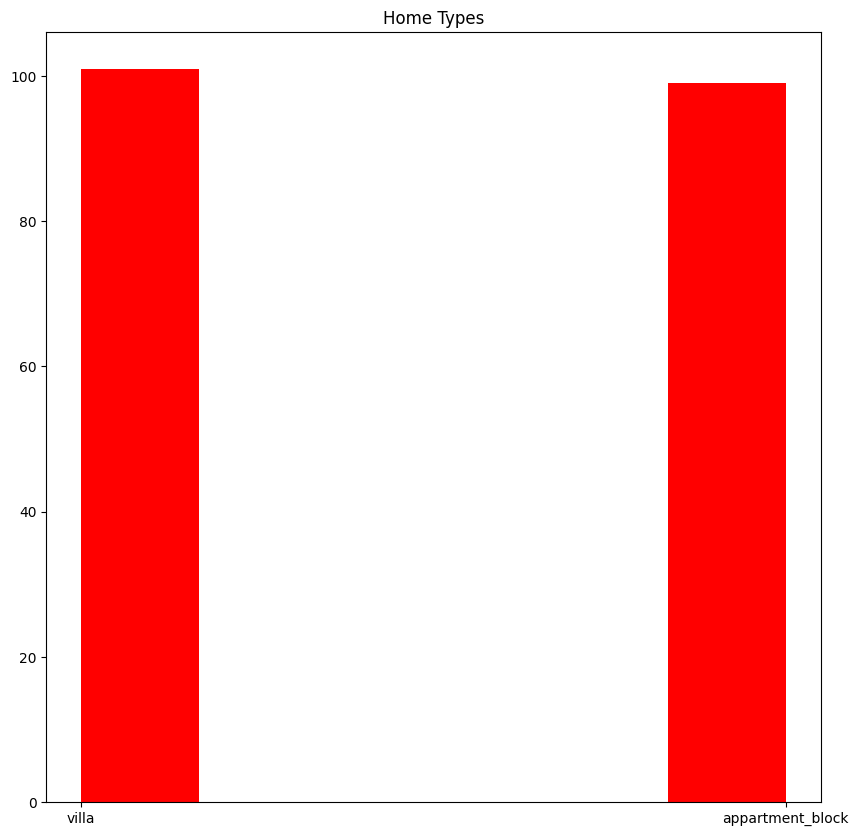

In [288]:
# Plot the type of homes that the users have
home_types = [user_info['home'].iloc[0]['poi_type_original'] for user_info in user_infos.values()]
plt.figure(figsize=(10, 10))
plt.title('Home Types')
plt.hist(home_types, bins=6, color='red')
plt.show()

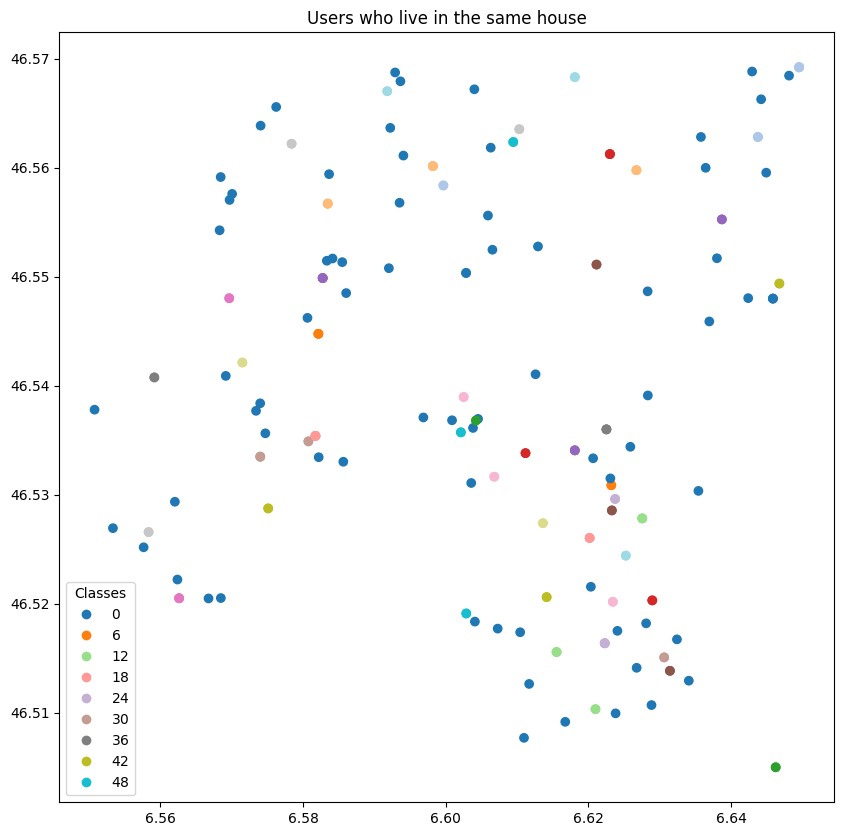

╒══════════════╤═══════════════════╕
│   Home Label │   Number of Users │
╞══════════════╪═══════════════════╡
│            0 │                 2 │
├──────────────┼───────────────────┤
│            1 │                 3 │
├──────────────┼───────────────────┤
│            2 │                 3 │
├──────────────┼───────────────────┤
│           -1 │                71 │
├──────────────┼───────────────────┤
│            3 │                 2 │
├──────────────┼───────────────────┤
│            4 │                 5 │
├──────────────┼───────────────────┤
│            5 │                 2 │
├──────────────┼───────────────────┤
│            6 │                 3 │
├──────────────┼───────────────────┤
│            7 │                 3 │
├──────────────┼───────────────────┤
│            8 │                 4 │
├──────────────┼───────────────────┤
│            9 │                 4 │
├──────────────┼───────────────────┤
│           10 │                 2 │
├──────────────┼───────────────────┤
│

In [289]:
# Find the users who live in the same house
home_locations = [user_info['home'].iloc[0][['lat', 'lon']].values for user_info in user_infos.values()]
home_locations = np.array(home_locations)
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.0001, min_samples=2)
home_labels = dbscan.fit_predict(home_locations)
# Plot the users who live in the same house
plt.figure(figsize=(10, 10))
plt.title('Users who live in the same house')
scatter = plt.scatter(home_locations[:, 1], home_locations[:, 0], c=home_labels, cmap='tab20')
# Create a legend
plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
plt.show()

# Get the ip addresses of the users who have the same home_label
home_label_users = {}
for i in range(len(home_labels)):
    if home_labels[i] not in home_label_users:
        home_label_users[home_labels[i]] = []
    home_label_users[home_labels[i]].append(queries['ip_address'].unique()[i])

# Represent this in a nice table
from tabulate import tabulate
print(tabulate([[key, len(home_label_users[key])] for key in home_label_users], headers=['Home Label', 'Number of Users'],tablefmt="fancy_grid",stralign="center" ))

### Note that label -1 means the point is an outlier, i.e. does NOT belong to any of the clusters. In our case this means the user lives alone.

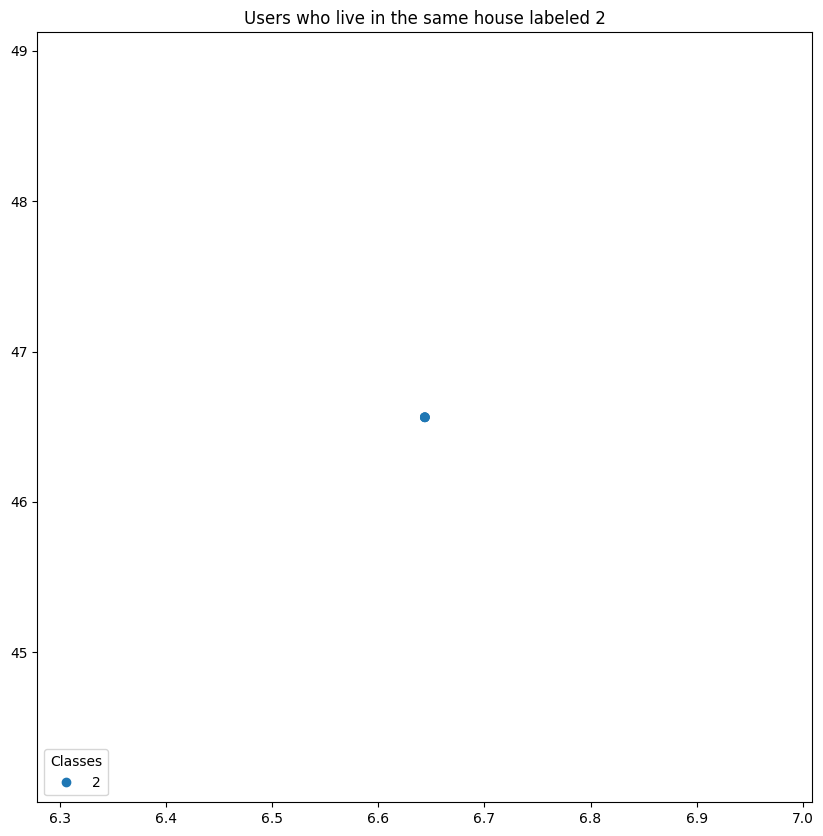

In [290]:
plt.figure(figsize=(10, 10))
plt.title('Users who live in the same house labeled 2')
scatter = plt.scatter(home_locations[home_labels == 2, 1], home_locations[home_labels == 2, 0], c=home_labels[home_labels == 2], cmap='tab20')
# Create a legend
plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")

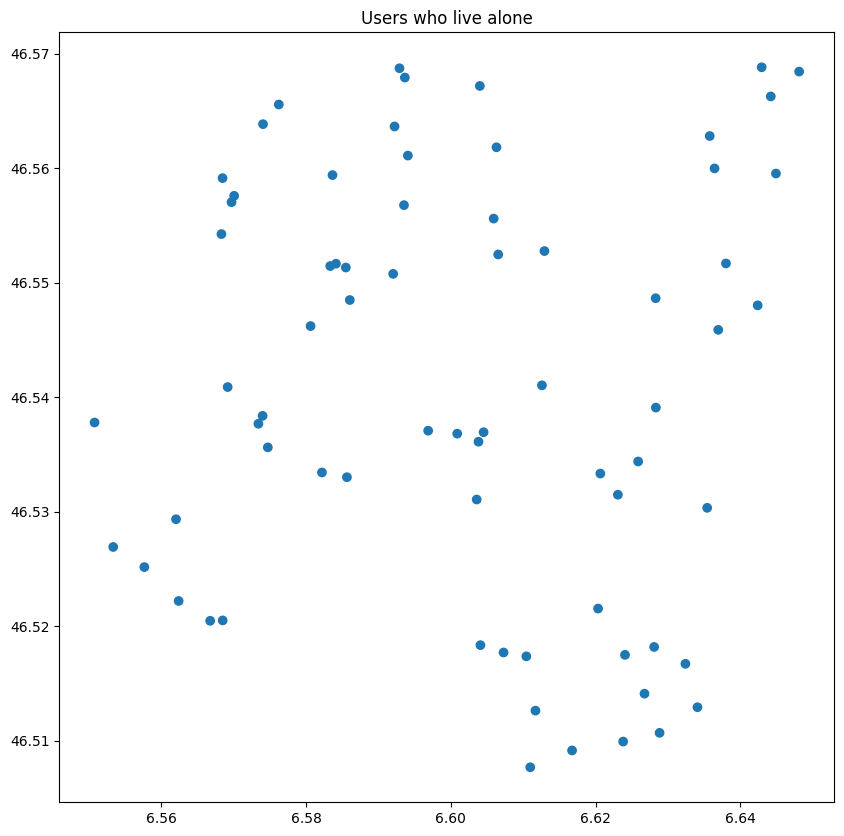

In [291]:
# Plot home location of label -1
plt.figure(figsize=(10, 10))
plt.title('Users who live alone')
scatter = plt.scatter(home_locations[home_labels == -1, 1], home_locations[home_labels == -1, 0], c=home_labels[home_labels == -1], cmap='tab20')
plt.show()

### Now for better visualization we print a table with House Label in one column and user's ip addresses in the other column, along with type of home

In [292]:
# Print a fancy table with tabulate that has 3 columns: 
# where one column is the house label and the other labels are the users ip addresses who live in that house, final column is the type of home, retrieved from poi_type_original
# Skip label -1 because it is the label for users who live alone
print(tabulate([[key, home_label_users[key], user_infos[home_label_users[key][0]]['home'].iloc[0]['poi_type_original']] for key in home_label_users if key != -1], headers=['Home Label', 'Users', 'Home Type'],tablefmt="fancy_grid",stralign="center" ))


╒══════════════╤═════════════════════════════════════════════════════════════════════════════════════════╤══════════════════╕
│   Home Label │                                          Users                                          │    Home Type     │
╞══════════════╪═════════════════════════════════════════════════════════════════════════════════════════╪══════════════════╡
│            0 │                           ['34.101.177.245', '189.222.3.241']                           │      villa       │
├──────────────┼─────────────────────────────────────────────────────────────────────────────────────────┼──────────────────┤
│            1 │                  ['244.190.169.115', '166.3.233.225', '103.75.228.13']                  │      villa       │
├──────────────┼─────────────────────────────────────────────────────────────────────────────────────────┼──────────────────┤
│            2 │                  ['60.235.63.253', '96.128.153.246', '18.204.22.223']                   │      villa 

In [293]:
user_infos['34.101.177.245']['home']

,ip_address,lat,lon,day,poi_type_query,day_of_week,hour_of_day,poi_type_query_original,poi_id,cell_id,poi_type,poi_type_original
30,34.101.177.245,46.550342,6.602852,0.0,meal,0.0,18.024657,restaurant,127,76,home,villa


In [294]:
user_infos['189.222.3.241']['home']

,ip_address,lat,lon,day,poi_type_query,day_of_week,hour_of_day,poi_type_query_original,poi_id,cell_id,poi_type,poi_type_original
30,189.222.3.241,46.550342,6.602852,0.0,entertainment,0.0,19.587954,club,127,76,home,villa


{2: 35, 3: 13, 5: 2, 4: 6}


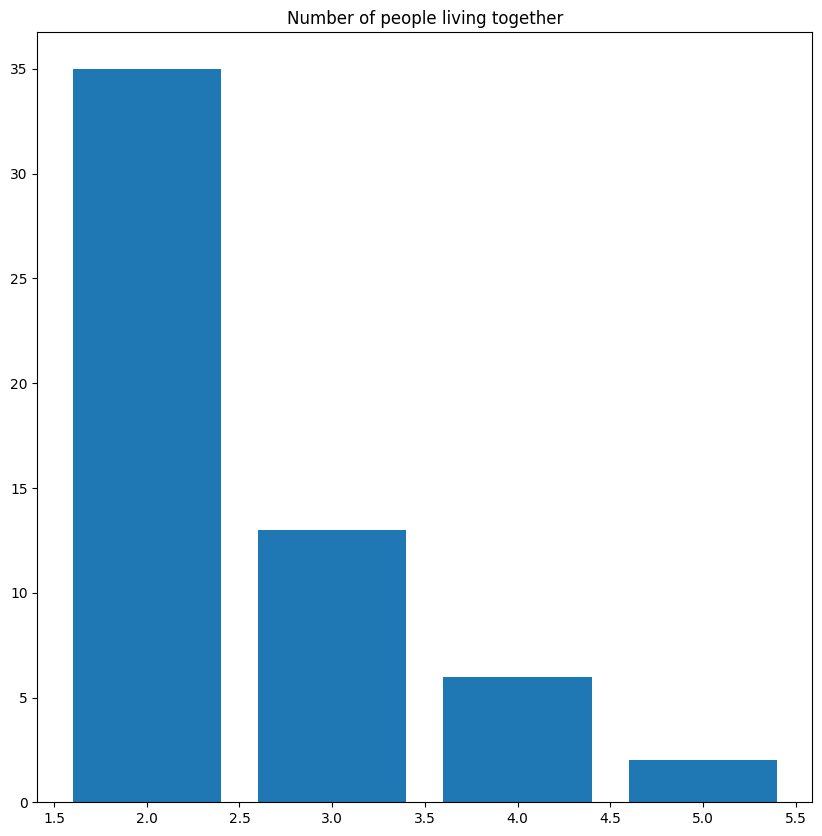

In [295]:
# We count how many people live alone, with 2 people, with 3 people, etc.
living_together = {}
for key in home_label_users:
    if key == -1:
        continue
    count = len(home_label_users[key])
    if count not in living_together:
        living_together[count] = 1
    living_together[count] += 1

print(living_together)
# Plot the number of people living together
plt.figure(figsize=(10, 10))
plt.title('Number of people living together')
plt.bar(living_together.keys(), living_together.values())
plt.show()

### We can do the same analysis for finding users working in the same place as well.

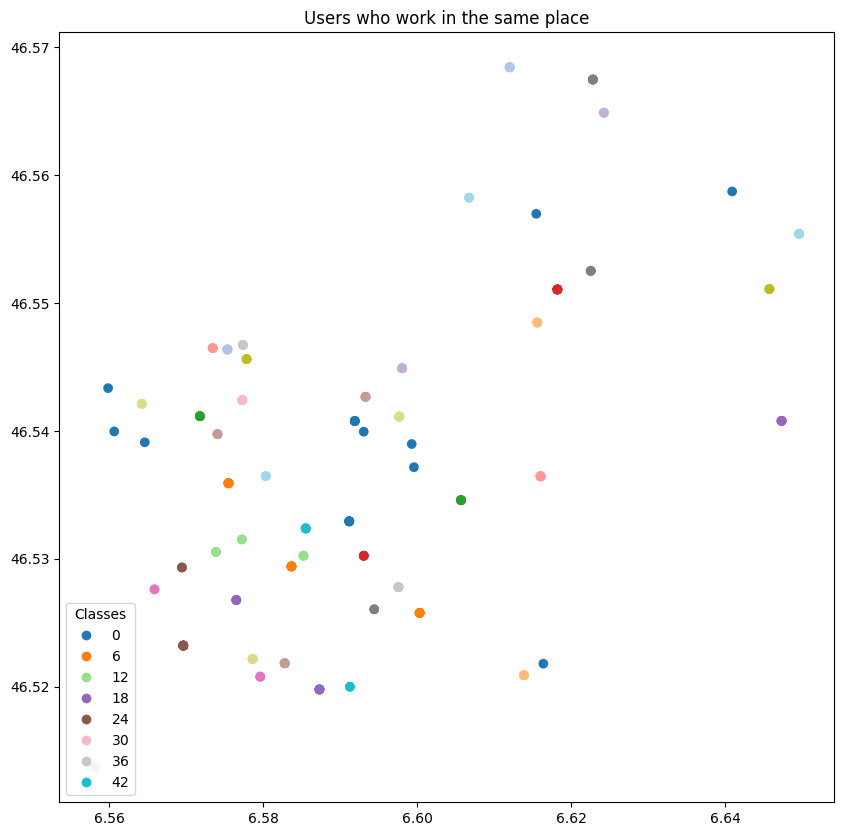

╒══════════════╤═══════════════════╕
│   Work Label │   Number of Users │
╞══════════════╪═══════════════════╡
│            0 │                 5 │
├──────────────┼───────────────────┤
│            1 │                 4 │
├──────────────┼───────────────────┤
│            2 │                 4 │
├──────────────┼───────────────────┤
│            3 │                 5 │
├──────────────┼───────────────────┤
│            4 │                 6 │
├──────────────┼───────────────────┤
│            5 │                 7 │
├──────────────┼───────────────────┤
│            6 │                 6 │
├──────────────┼───────────────────┤
│            7 │                 3 │
├──────────────┼───────────────────┤
│            8 │                 3 │
├──────────────┼───────────────────┤
│            9 │                 5 │
├──────────────┼───────────────────┤
│           10 │                 5 │
├──────────────┼───────────────────┤
│           11 │                 3 │
├──────────────┼───────────────────┤
│

In [296]:
# We repeat the same process for work locations
work_locations = [user_info['work'].iloc[0][['lat', 'lon']].values for user_info in user_infos.values()]
work_locations = np.array(work_locations)
dbscan = DBSCAN(eps=0.0001, min_samples=2)
work_labels = dbscan.fit_predict(work_locations)
plt.figure(figsize=(10, 10))
plt.title('Users who work in the same place')
scatter = plt.scatter(work_locations[:, 1], work_locations[:, 0], c=work_labels, cmap='tab20')
# Create a legend
plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
plt.show()

# Get the ip addresses of the users who have the same work_label
work_label_users = {}
for i in range(len(work_labels)):
    if work_labels[i] not in work_label_users:
        work_label_users[work_labels[i]] = []
    work_label_users[work_labels[i]].append(queries['ip_address'].unique()[i])


# Represent this in a nice table
print(tabulate([[key, len(work_label_users[key])] for key in work_label_users], headers=['Work Label', 'Number of Users'],tablefmt="fancy_grid",stralign="center" ))

### Now for better visualization we print a table with work Label in one column and user's ip addresses in the other column, along with type of work place

In [299]:
# Print a fancy table with tabulate that has 3 columns:
# where one column is the work label and the other labels are the users ip addresses who work in that place, final column is the type of work, retrieved from poi_type_original
# Skip label -1 because it is the label for users who work alone
print(tabulate([[key, work_label_users[key], user_infos[work_label_users[key][0]]['work'].iloc[0]['poi_type_original']] for key in work_label_users if key != -1], headers=['Work Label', 'Users', 'Work Type'],tablefmt="fancy_grid",stralign="center" ))

╒══════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════════╕
│   Work Label │                                                                                     Users                                                                                     │  Work Type  │
╞══════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪═════════════╡
│            0 │                                          ['34.101.177.245', '104.149.206.168', '202.161.113.142', '250.163.7.81', '105.148.239.144']                                          │   company   │
├──────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### Now finally, it is also possible to repeat this experiment but by using both the work place and home place

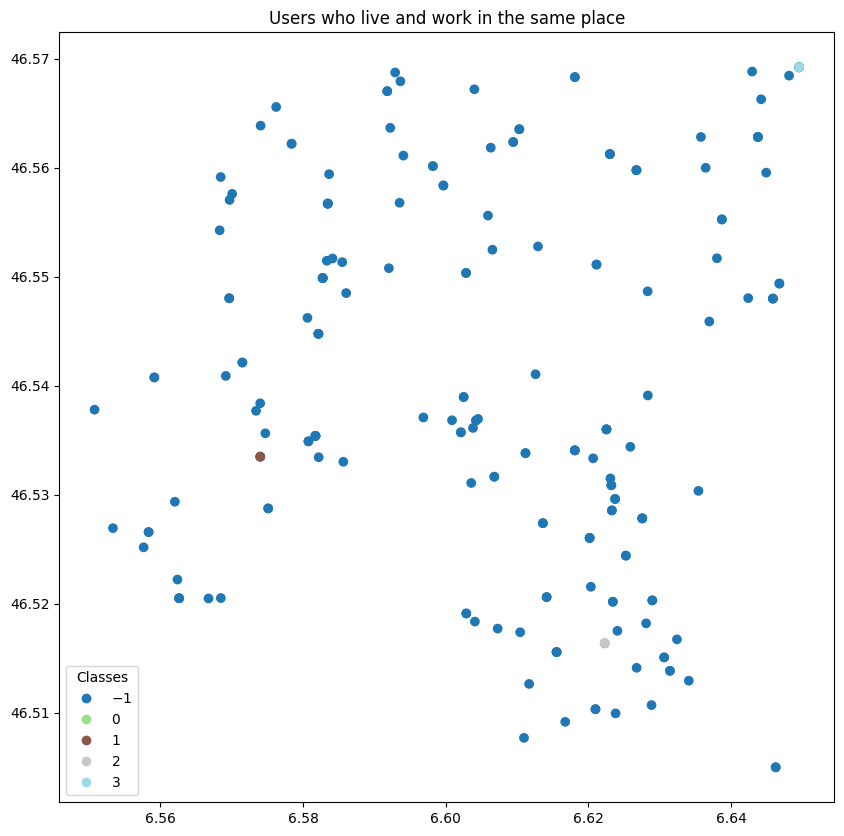

╒═══════════════════╤═══════════════════╕
│   Home Work Label │   Number of Users │
╞═══════════════════╪═══════════════════╡
│                -1 │               191 │
├───────────────────┼───────────────────┤
│                 0 │                 2 │
├───────────────────┼───────────────────┤
│                 1 │                 2 │
├───────────────────┼───────────────────┤
│                 2 │                 3 │
├───────────────────┼───────────────────┤
│                 3 │                 2 │
╘═══════════════════╧═══════════════════╛


In [300]:
# Now repeat the above processes but this time use both home and work locations to find users who live and work in the same place
# Firstly for each user in user_infos, we concatenate the home and work locations
home_work_locations = [np.concatenate([user_info['home'].iloc[0][['lat', 'lon']].values, user_info['work'].iloc[0][['lat', 'lon']].values]) for user_info in user_infos.values()]
home_work_locations = np.array(home_work_locations)
dbscan = DBSCAN(eps=0.0001, min_samples=2)
home_work_labels = dbscan.fit_predict(home_work_locations)
plt.figure(figsize=(10, 10))
plt.title('Users who live and work in the same place')
scatter = plt.scatter(home_work_locations[:, 1], home_work_locations[:, 0], c=home_work_labels, cmap='tab20')
# Create a legend
plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
plt.show()

# Get the ip addresses of the users who have the same home_work_label
home_work_label_users = {}
for i in range(len(home_work_labels)):
    if home_work_labels[i] not in home_work_label_users:
        home_work_label_users[home_work_labels[i]] = []
    home_work_label_users[home_work_labels[i]].append(queries['ip_address'].unique()[i])


# Represent this in a nice table
print(tabulate([[key, len(home_work_label_users[key])] for key in home_work_label_users], headers=['Home Work Label', 'Number of Users'],tablefmt="fancy_grid",stralign="center" ))

In [301]:
# Print a fancy table with tabulate that has 4 columns:
# where one column is the home_work label and the other labels are the users ip addresses who live and work in that place, final 2 columns are the type of home and work, retrieved from poi_type_original
# Skip label -1 because it is the label for users who live and work alone
print(tabulate([[key, home_work_label_users[key], user_infos[home_work_label_users[key][0]]['home'].iloc[0]['poi_type_original'], user_infos[home_work_label_users[key][0]]['work'].iloc[0]['poi_type_original']] for key in home_work_label_users if key != -1], headers=['Home Work Label', 'Users', 'Home Type', 'Work Type'],tablefmt="fancy_grid",stralign="center" ))

╒═══════════════════╤════════════════════════════════════════════════════════╤═════════════╤═════════════╕
│   Home Work Label │                         Users                          │  Home Type  │  Work Type  │
╞═══════════════════╪════════════════════════════════════════════════════════╪═════════════╪═════════════╡
│                 0 │          ['135.104.79.52', '233.228.129.122']          │    villa    │   company   │
├───────────────────┼────────────────────────────────────────────────────────┼─────────────┼─────────────┤
│                 1 │         ['113.244.164.228', '126.107.209.19']          │    villa    │ laboratory  │
├───────────────────┼────────────────────────────────────────────────────────┼─────────────┼─────────────┤
│                 2 │ ['37.238.140.76', '245.191.255.251', '131.210.249.71'] │    villa    │   office    │
├───────────────────┼────────────────────────────────────────────────────────┼─────────────┼─────────────┤
│                 3 │          ['210.

#### Why this analysis makes sense is simple, when we analyze people who are living together, an attacker has 2 inferences he/she can make. Either these people are family that live together or they are roommates. In both cases, the attacker can infer that these people are close to each other and have a high chance of being friends.

#### But when we also put the work place into the equation, we can infer that these people are most likely colleagues if they also work in the same place while also living together.

# Other Inferences: Using Shopping, Meal, Hobby and etc. POIs

User: 34.101.177.245 has attended a meal at location: (46.52580438335738, 6.579521803737147) at time: 5.0|9.43546959845645
User: 34.101.177.245 has attended a meal at location: (46.534387638970315, 6.620945617202634) at time: 5.0|9.43546959845645
User: 34.101.177.245 has attended a meal at location: (46.552574267941566, 6.558613655249042) at time: 5.0|9.43546959845645
User: 34.101.177.245 has attended a meal at location: (46.530298174512545, 6.561513086016163) at time: 5.0|9.43546959845645
User: 34.101.177.245 has attended a meal at location: (46.509526718695874, 6.642143586188201) at time: 5.0|9.43546959845645
User: 34.101.177.245 has attended a meal at location: (46.51079863007427, 6.6432881558265775) at time: 5.0|9.43546959845645
User: 34.101.177.245 has attended a meal at location: (46.52056200494824, 6.577343198293258) at time: 5.0|9.43546959845645
User: 34.101.177.245 has attended a meal at location: (46.514209687929835, 6.577225267686699) at time: 5.0|9.43546959845645
User: 244.

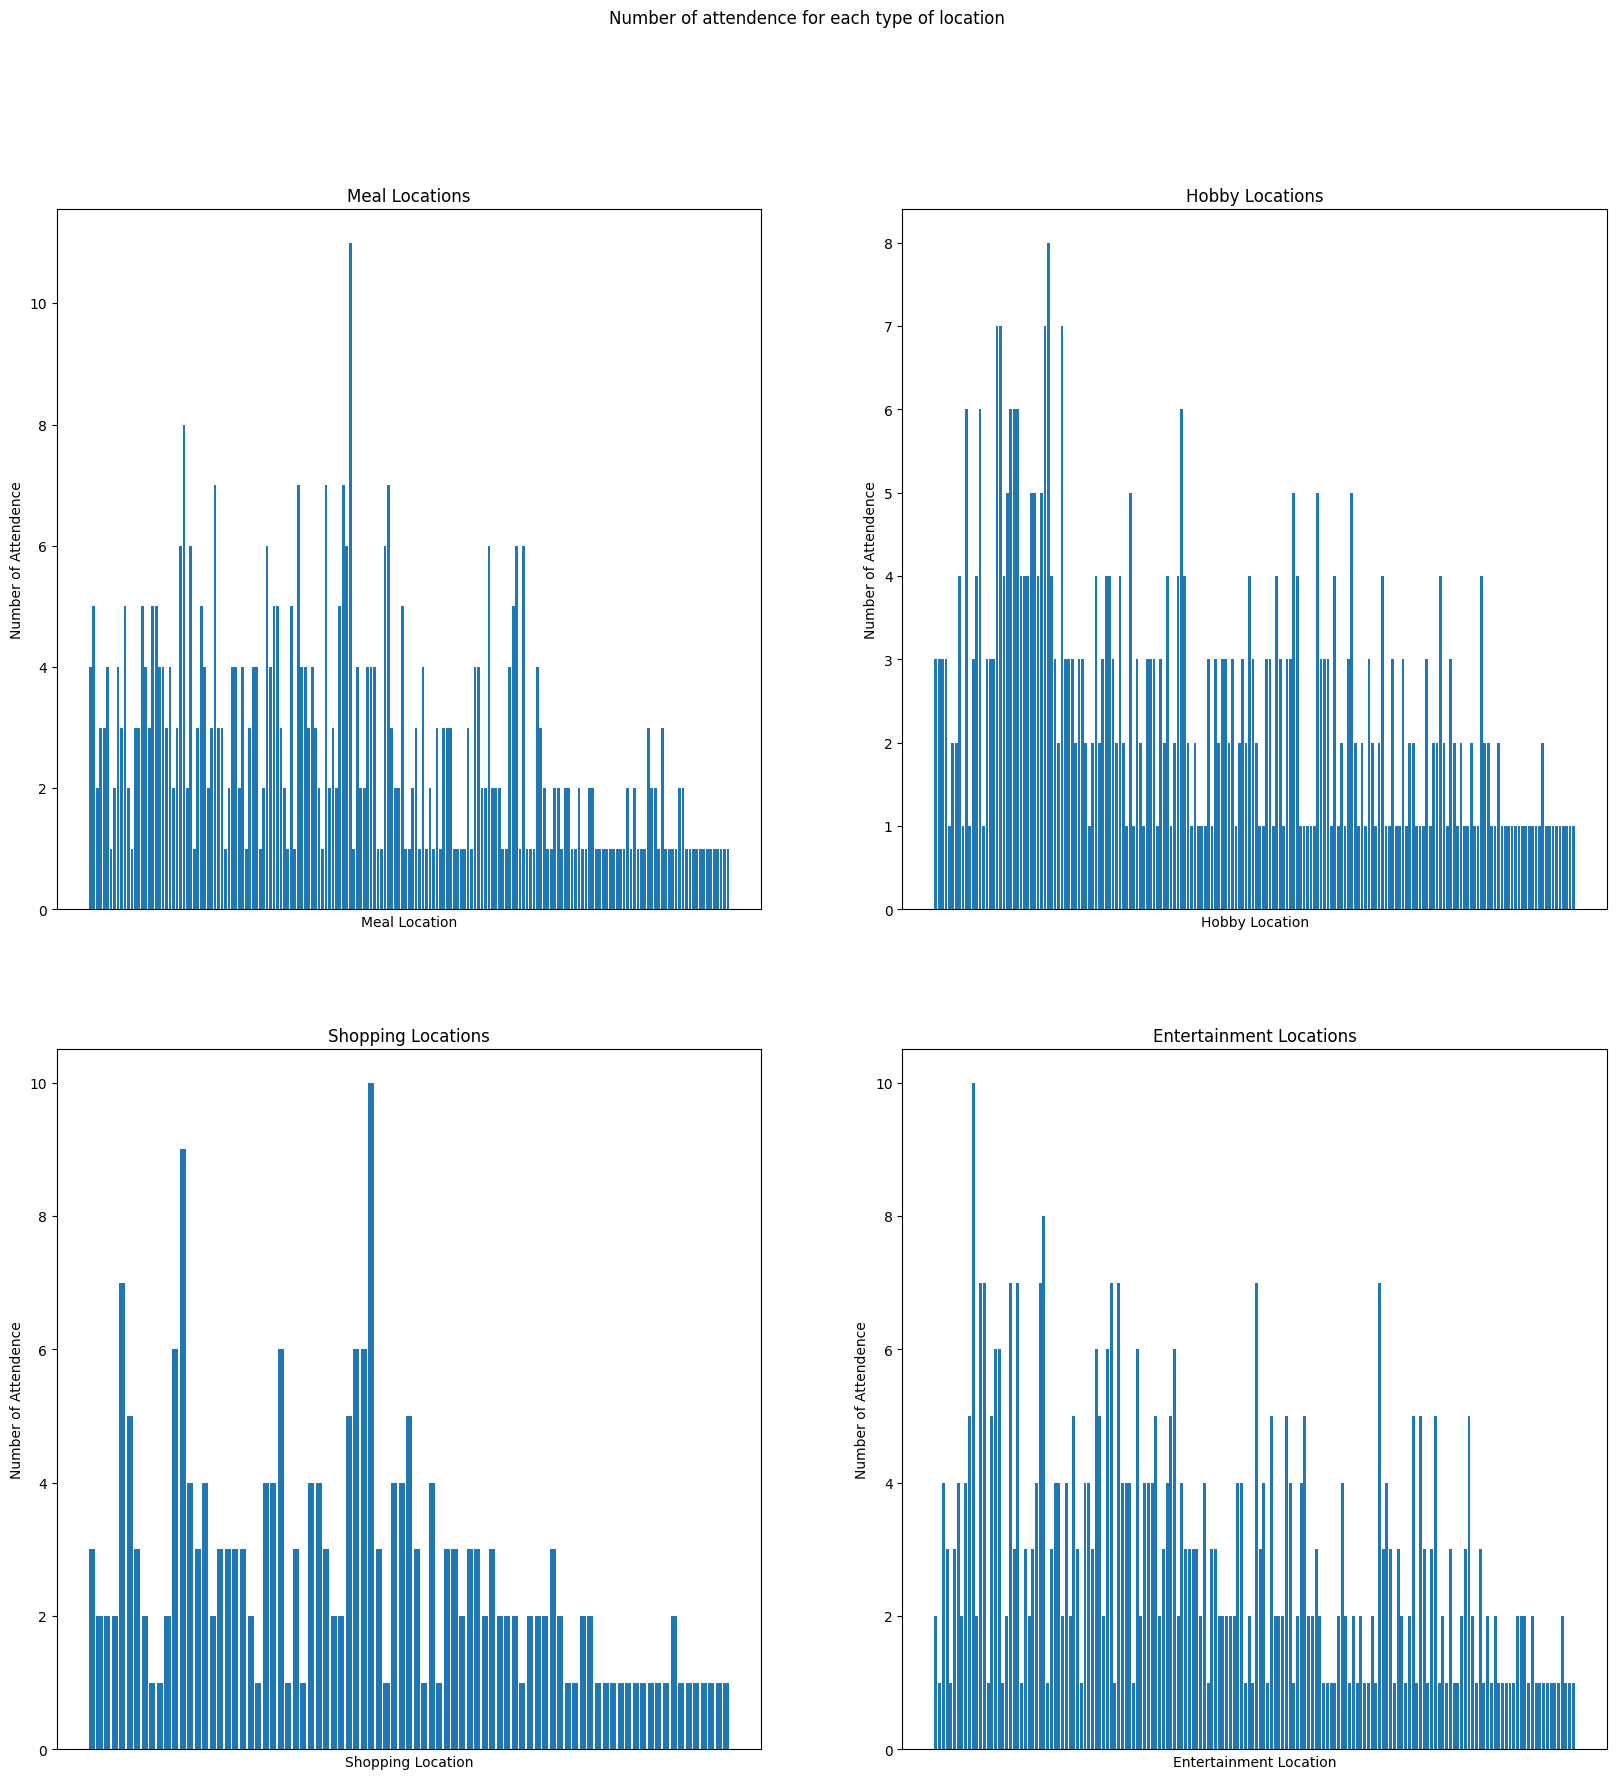

In [317]:
# Now we will be looking at other types of locations, such as Meal, Hobby, Shopping entertainement etc.
# First thing we can take a look at is the number of attendence for each type of location
# We will be using the poi_type column to get the type of location
# For each of these locations we will have one plot
# So one plot for Meal, one plot for Hobby, one plot for Shopping, one plot for Entertainment

# In each of these plots we will have one bar for each sub-type of location,
# To be able to do this we will need to get the sub-type of location for each location
# We will use the lat, lon coordinates to get the sub-type of location
# We will use the poi_type column to get the type of location

merged = queries.merge(queries, on=['lat', 'lon'], how='inner')

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Number of attendence for each type of location')

meal_locations = {}
hobby_locations = {}
shopping_locations = {}
entertainment_locations = {}

for user_info in user_infos.values():
    # Get the meal locations:
    user_meal_locations = user_info['meal'][['lat', 'lon']].values
    for user_meal_location in user_meal_locations:
        if tuple(user_meal_location) not in meal_locations:
            meal_locations[tuple(user_meal_location)] = 0
        meal_locations[tuple(user_meal_location)] += 1
        #print(f'User: {user_info["user"]} has attended a meal at location: {tuple(user_meal_location)} at time: {user_info["meal"].iloc[0]["day"]}|{user_info["meal"].iloc[0]["hour_of_day"]}')
    
    # Get the hobby locations:
    user_hobby_locations = user_info['hobby'][['lat', 'lon']].values
    for user_hobby_location in user_hobby_locations:
        if tuple(user_hobby_location) not in hobby_locations:
            hobby_locations[tuple(user_hobby_location)] = 0
        hobby_locations[tuple(user_hobby_location)] += 1
    
    # Get the shopping locations:
    user_shopping_locations = user_info['shopping'][['lat', 'lon']].values
    for user_shopping_location in user_shopping_locations:
        if tuple(user_shopping_location) not in shopping_locations:
            shopping_locations[tuple(user_shopping_location)] = 0
        shopping_locations[tuple(user_shopping_location)] += 1
    
    # Get the entertainment locations:
    user_entertainment_locations = user_info['entertainment'][['lat', 'lon']].values
    for user_entertainment_location in user_entertainment_locations:
        if tuple(user_entertainment_location) not in entertainment_locations:
            entertainment_locations[tuple(user_entertainment_location)] = 0
        entertainment_locations[tuple(user_entertainment_location)] += 1
    

# Now we have 4 dictionaries, each dictionary has the coordinates of the location as the key and the number of attendence as the value
# We will now plot these dictionaries

# Plot the meal locations
ax[0, 0].set_title('Meal Locations')
ax[0, 0].set_xlabel('Meal Location')
ax[0, 0].set_ylabel('Number of Attendence')
# Remove x axis ticks
ax[0, 0].set_xticks([])
ax[0, 0].bar([str(key) for key in meal_locations], [meal_locations[key] for key in meal_locations])

# Plot the hobby locations
ax[0, 1].set_title('Hobby Locations')
ax[0, 1].set_xlabel('Hobby Location')
ax[0, 1].set_ylabel('Number of Attendence')
# Remove x axis ticks
ax[0, 1].set_xticks([])
ax[0, 1].bar([str(key) for key in hobby_locations], [hobby_locations[key] for key in hobby_locations])

# Plot the shopping locations
ax[1, 0].set_title('Shopping Locations')
ax[1, 0].set_xlabel('Shopping Location')
ax[1, 0].set_ylabel('Number of Attendence')
# Remove x axis ticks
ax[1, 0].set_xticks([])
ax[1, 0].bar([str(key) for key in shopping_locations], [shopping_locations[key] for key in shopping_locations])

# Plot the entertainment locations
ax[1, 1].set_title('Entertainment Locations')
ax[1, 1].set_xlabel('Entertainment Location')
ax[1, 1].set_ylabel('Number of Attendence')
# Remove x axis ticks
ax[1, 1].set_xticks([])
ax[1, 1].bar([str(key) for key in entertainment_locations], [entertainment_locations[key] for key in entertainment_locations])

plt.show()





In [313]:
# Find the most popular meal, hobby, shopping and entertainment locations

# First the meal location
# We will use the meal_locations dictionary that we created above
# We will sort the dictionary by the number of attendence
for key in sorted(meal_locations, key=meal_locations.get, reverse=True):
    print(key, meal_locations[key])
    break

# Now the hobby location
for key in sorted(hobby_locations, key=hobby_locations.get, reverse=True):
    print(key, hobby_locations[key])
    break

# Now the shopping location
for key in sorted(shopping_locations, key=shopping_locations.get, reverse=True):
    print(key, shopping_locations[key])
    break

# Now the entertainment location
for key in sorted(entertainment_locations, key=entertainment_locations.get, reverse=True):
    print(key, entertainment_locations[key])
    break


(46.515853182301285, 6.620696945936285) 11
(46.556516722962456, 6.593581353284495) 8
(46.51907799910527, 6.623836875862341) 10
(46.55626358771141, 6.591222669318815) 10
